<a href="https://colab.research.google.com/github/LarsHadidi/PRONTO/blob/mathprogram/mp/PDP-AQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progressive Dinner Party: Constrained Quadratic Model

# Method: Adiabatic Quantum Computing

**Using the D-Wave Quantum Annealer**

D-Wave Systems' hybrid solver can handle optimization problems with up to 1 million variables (including continuous variables) and 100,000 constraints. In addition, D-Wave has introduced a new pre-solver set of fast classical algorithms that reduces the size of the problem and allows for larger models to be submitted to the hybrid solver.

[https://www.dwavesys.com/media/rldh2ghw/14-1055a-a_hybrid_solver_for_constrained_quadratic_models.pdf](https://www.dwavesys.com/media/rldh2ghw/14-1055a-a_hybrid_solver_for_constrained_quadratic_models.pdf)

<img src="https://www.hpcwire.com/wp-content/uploads/2022/11/D_Wave_CQM-Graphic_v5.jpg" alt="DWave" width="50%"/>

## Hosted Runtime

In [17]:
!pip install -q dwave-ocean-sdk

## Imports

In [18]:
import dimod
import pickle
import getpass
import itertools
import numpy as np
import networkx as nx
import ipywidgets as widgets
from google.colab import files
import matplotlib.pyplot as plt
from dwave.system import LeapHybridCQMSampler 

## Data

In [19]:
w_size = widgets.IntText(description='Size', orientation='horizontal', value=9, min=9)
w_cluster = widgets.IntText(description='Clusters', orientation='horizontal', value=1, min=1)
w_deviation = widgets.FloatText(description='Deviation', orientation='horizontal', value=0.1, min=0)
w_scale = widgets.IntText(description='Scaling', orientation='horizontal', value=1)
display(widgets.Box([w_size, w_cluster,w_deviation, w_scale], layout=widgets.Layout(display='flex', flex_flow='row')))

Box(children=(IntText(value=9, description='Size'), IntText(value=1, description='Clusters'), FloatText(value=…

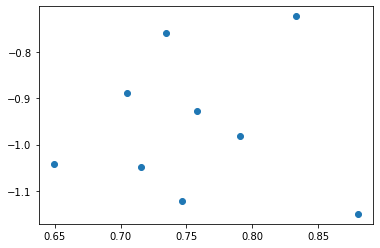

In [21]:
rng = np.random.default_rng()

N = w_size.value
K = w_cluster.value
σ = w_deviation.value
λ = w_scale.value

assert N >= 9
assert K > 0
assert N % K == 0
assert N % 3 == 0
assert σ >= 0
assert λ > 0

points = {}
centers = rng.uniform(-1, 1, (K, 2))
for i in range(K):
	points[str(centers[i])] = λ * rng.normal(centers[i], σ, (N // K, 2))

X = np.array(list(points.values())).reshape(N, 2)[:,0]
Y = np.array(list(points.values())).reshape(N, 2)[:,1]

G = nx.DiGraph()
for i in range(N):
	G.add_node(i, x = X[i], y = Y[i])

C = np.empty((N,N))
for a,b in itertools.product(range(N), range(N)):
	dX = (X[b]-X[a]) * (X[b]-X[a])
	dY = (Y[b]-Y[a]) * (Y[b]-Y[a])
	C[a,b] = np.sqrt(dX + dY)

plt.scatter(X,Y)
plt.show()

## Implementation

In [22]:
cqm = dimod.ConstrainedQuadraticModel()

In [35]:
t = np.array([[[[dimod.Binary(f't_{i}_{j}_{k}_{l}') for l in range(N)] for k in range(N)] for j in range(N)] for i in range(N)])
e = np.array([[dimod.Binary(f'e_{i}_{j}') for j in range(N)] for i in range(N)])
s = np.array([dimod.Binary(f's_{i}') for i in range(N)])
m = np.array([dimod.Binary(f'm_{i}') for i in range(N)])
d = np.array([dimod.Binary(f'd_{i}') for i in range(N)])

cqm.set_objective(dimod.quicksum(C[i,j] * e[i][j] for i,j in itertools.product(range(N), range(N))))

for i in range(N):
  cqm.add_constraint(s[i] + m[i] + d[i] == 1)
  
  cqm.add_constraint(dimod.quicksum( s[i] * e[:,i] ) == 0)
  cqm.add_constraint(dimod.quicksum( s[i] * e[i,:] ) - 3 * s[i] == 0)

  cqm.add_constraint(dimod.quicksum( m[i] * e[:,i] ) - 3 * m[i] == 0)
  cqm.add_constraint(dimod.quicksum( m[i] * e[i,:] ) - 3 * m[i] == 0)

  cqm.add_constraint(dimod.quicksum( d[i] * e[:,i] ) - 3 * d[i] == 0)
  cqm.add_constraint(dimod.quicksum( d[i] * e[i,:] ) == 0)

  cqm.add_constraint(dimod.quicksum(m) * 3 == N)
  cqm.add_constraint(dimod.quicksum( t[i,u,v,w] for u,v,w in itertools.product(range(N), repeat=3)) == 1)

for i,j in itertools.product(range(N), range(N)):
  cqm.add_constraint(s[i] * e[i][j] + d[j] <= 1)
  if i != j:
    cqm.add_constraint(dimod.quicksum((dimod.quicksum(t[i, u,v,w] for v in range(N) for w in range(N)) + dimod.quicksum(t[j, u,v,w] for v in range(N) for w in range(N))) * (dimod.quicksum(t[i, u,v,w] for v in range(N) for w in range(N)) + dimod.quicksum(t[j, u,v,w] for v in range(N) for w in range(N))) for u in range(N)) + dimod.quicksum((dimod.quicksum(t[i, u,v,w] for u in range(N) for w in range(N)) + dimod.quicksum(t[j, u,v,w] for u in range(N) for w in range(N))) * (dimod.quicksum(t[i, u,v,w] for u in range(N) for w in range(N)) + dimod.quicksum(t[j, u,v,w] for u in range(N) for w in range(N))) for v in range(N)) + dimod.quicksum((dimod.quicksum(t[i, u,v,w] for u in range(N) for v in range(N)) + dimod.quicksum(t[j, u,v,w] for u in range(N) for v in range(N))) * (dimod.quicksum(t[i, u,v,w] for u in range(N) for v in range(N)) + dimod.quicksum(t[j, u,v,w] for u in range(N) for v in range(N))) for w in range(N)) <= 8)

for l,i,j,k in itertools.product(range(N), repeat=4):
  cqm.add_constraint(t[l][i][j][k] - e[i][j]*e[j][k] <= 0)

In [36]:
sampler = LeapHybridCQMSampler(token=getpass.getpass())
sampleset = sampler.sample_cqm(cqm, label="PDP Optimization")

··········


In [38]:
print(f"QPU Time: {sampleset.info['qpu_access_time'] / 1e6:06.3f}s")

QPU Time: 00.016s


In [40]:
sol = sampleset.filter(lambda sample: sample.is_feasible).lowest().to_pandas_dataframe(sample_column=True)
print(len(sol))

1


In [41]:
with open('solution', 'wb') as f:
  pickle.dump(sol, f)

files.download('solution')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('solution', 'rb') as f:
  sol = pickle.load(f)

In [42]:
sol

,sample,energy,num_occurrences,is_satisfied,is_feasible
0,"{'d_0': 0.0, 'd_1': 0.0, 'd_2': 0.0, 'd_3': 1....",3.355916,1,"[True, True, True, True, True, True, True, Tru...",True


In [43]:
smp = sol.iloc[0]['sample']

In [44]:
s = np.array([smp[f's_{i}'] for i in range(N)])
m = np.array([smp[f'm_{i}'] for i in range(N)])
d = np.array([smp[f'd_{i}'] for i in range(N)])
e = np.array([[smp[f'e_{i}_{j}'] for j in range(N)] for i in range(N)])
t = np.array([[[[smp[f't_{i}_{j}_{k}_{l}'] for l in range(N)] for k in range(N)] for j in range(N)] for i in range(N)])

## Results

In [45]:
def draw_graph(nodes: dict, edges: list):
	G = nx.DiGraph()
	G.add_nodes_from(nodes)
	G.add_edges_from(edges)
	pos = {k: list(v.values()) for k, v in nodes.items()}
	edge_colors = nx.get_edge_attributes(G,'color').values()
	node_colors = np.array(list(dict(G.in_degree(G.nodes)).values())) - np.array(list(dict(G.out_degree(G.nodes)).values()))
  

	nx.draw(
			G, pos,
			edge_color = edge_colors,
			edge_cmap = plt.cm.get_cmap('Set3'),
			node_color = node_colors,
			width=3, node_size=50, connectionstyle='arc3,rad=0.1')
	plt.show()

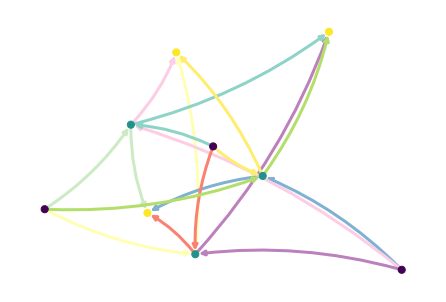

In [47]:
tours = [(l,i,j,k) for l in range(N) for i in range(N) for j in range(N) for k in range(N) if t[l, i,j,k] == 1]
edges = []
for (l,i,j,k) in tours:
	edges.append((i, j, {'color':l}))
	edges.append((j, k, {'color':l}))

nodes = dict(G.nodes(data=True))

draw_graph(nodes, edges)